In [1]:
import time
from multiprocessing import Pool

from IPython.display import display

from pylab import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from itertools import cycle
lstyle = cycle(('-', '--', ':', '-.',\
    (0, (1, 10)), (0, (5, 10)),\
    (0, (5, 5)), (0, (3, 10, 1, 10)),\
    (0, (3, 5, 1, 5)), \
    (0, (3, 5, 1, 5, 1, 5))))
color = cycle(('#1f77b4', '#ff7f0e', '#2ca02c',\
    '#d62728', '#9467bd', '#8c564b', '#e377c2',\
    '#7f7f7f', '#bcbd22', '#17becf'))


from scipy.sparse import *
from scipy.sparse.linalg import spsolve

**Taylor decaying**

This is a classical Navier-Stokes problem, in general used to state the con-
vergence order of the considered formulae. Exact solution is
\begin{equation} \label{eq1}
\left\lbrace 
\begin{array}{l}
 u = -e^{-2t/\mathrm{Re}} \cos(x) \sin(y) ,\\
 v =  e^{-2t/\mathrm{Re}} \sin(x) \cos(y) ,\\
 p = -e^{-4t/\mathrm{Re}} (\cos(2x) + \cos(2y))/4 ,
\end{array}
\right. 
\end{equation} 
in $[0, 2\pi]\times[0, 2\pi]\times[0, 1]$, where the Reynolds number $\mathrm{Re} = 10^{2}$, 
$\tau=0.05h$.

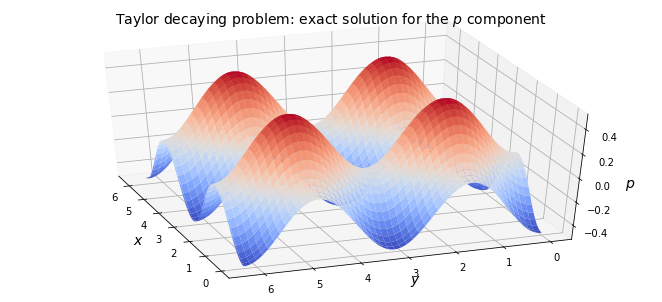

In [2]:
def taylor_decaying_u(t, X, Re):
    x, y = X
    return -exp(-2.*t/Re)*cos(x)*sin(y)
#     return exp(-2.*t/Re)*sin(x)*cos(y)
def taylor_decaying_v(t, X, Re):
    x, y = X
    return exp(-2.*t/Re)*sin(x)*cos(y)
#     return -exp(-2.*t/Re)*cos(x)*sin(y)
def taylor_decaying_p(t, X, Re):
    x, y = X
    return -exp(-4.*t/Re)*(cos(2.*x)+cos(2.*y))/4.

h, Re = 2.5e-2, 1.e2
X = meshgrid(arange(0., 2.*pi, h, dtype=float64),\
             arange(0., 2.*pi, h, dtype=float64), indexing='ij')

fig = figure(figsize=(9, 4))
axes = Axes3D(fig)
axes.plot_surface(X[0], X[1], taylor_decaying_p(0., X, Re), \
                  rstride=5, cstride=5, cmap=cm.coolwarm)
axes.set_xlabel(r"$x$", {'fontsize': 14})
axes.set_ylabel(r"$y$", {'fontsize': 14})
axes.set_zlabel(r"$p$", {'fontsize': 14})
axes.set_title(r"Taylor decaying problem: exact solution for the $p$ component",\
               {'fontsize': 14})
axes.view_init(azim=160., elev=40.)
show()
# savefig('./taylor_decaying_exact_p.pdf')
close()


In [3]:
def A_cross1(Nx, Ny):
    Nxy = Nx*Ny
    def jk(j, k):
        return j*Ny+k
    
    row = empty((Nx, Ny, 5), dtype=int)
    for j in range(Nx):
        for k in range(Ny):
            row[j, k] = jk(j, k)

    col = zeros((Nx, Ny, 5), dtype=int)
    for j in range(1, Nx-1):
        for k in range(1, Ny-1):
            col[j, k] =             jk(j-1, k),\
                        jk(j, k-1), jk(j, k), jk(j, k+1),\
                                    jk(j+1, k)
    for j in range(Nx):
        col[j, 0, 0] = jk(j, 0)
        col[j, -1, 0] = jk(j, Ny-1)
    for k in range(1, Ny-1):
        col[0, k, 0]  = jk(0, k)
        col[-1, k, 0] = jk(Nx-1, k)

    data = zeros((Nx, Ny, 5), dtype=float64)
    data[1:-1, 1:-1] =      1.,\
                       1., -4.,  1.,\
                            1.
    data[:, 0, 0] = 1.
    data[:, -1, 0] = 1.
    data[0, 1:-1, 0] = 1.
    data[-1, 1:-1, 0] = 1.

    A = csr_matrix((data.reshape(Nxy*5),\
                    (row.reshape(Nxy*5), col.reshape(Nxy*5))),\
                   shape=(Nxy, Nxy))
    return A

def solve_1(A, b):
    Nx, Ny = b.shape
    u = spsolve(A, b.reshape(Nx*Ny)).reshape(Nx,Ny)
    return u

С. A. J. Fletcher Computational Techniques for Fluid Dynamics 2<br>
pages 331-336<br>
http://library.lol/main/93572266F3EF7DF0E555084A75EC4BBC
<img src="./F17.1.png"/>

<img src="./F17.png"/>

$$
u_{j,\ k} = 0.5(u_{j-1/2,\ k} + u_{j+1/2,\ k})
$$
$$
(uv)_{j+1/2,\ k-1/2} = [(u_{j+1/2,\ k-1} + u_{j+1/2,\ k})/2][(v_{j+1,\ k-1/2} + v_{j,\ k-1/2})/2]
$$

<img src="./F17.3.png"/>

$$
v_{j,\ k+1} = 0.5(v_{j,\ k+1/2} + v_{j,\ k+3/2})
$$
$$
v_{j,\ k} = 0.5(v_{j,\ k-1/2} + v_{j,\ k+1/2})
$$
$$
(uv)_{j+1/2,\ k+1/2} = [(u_{j+1/2,\ k} + u_{j+1/2,\ k+1})/2][(v_{j+1,\ k+1/2} + v_{j,\ k+1/2})/2]
$$
$$
(uv)_{j-1/2,\ k+1/2} = [(u_{j-1/2,\ k} + u_{j-1/2,\ k+1})/2][(v_{j,\ k+1/2} + v_{j-1,\ k+1/2})/2]
$$

<img src="./F17.11.png"/>

In [4]:
def MAC(A, S, F, BC, tau, h, Re):
    assert tau/(Re*h**2) < 1./4.
    u, v, p = F
    left, top, right, bottom = BC
    u1, v1, p1 = empty_like(u), empty_like(v), empty_like(p)

    u1[0, :],  v1[0, :],  p1[0, :] = left
    u1[:, -1], v1[:, -1], p1[:, -1] = top
    u1[-1, :], v1[-1, :], p1[-1, :] = right
    u1[:, 0],  v1[:, 0],  p1[:, 0] = bottom
    
    F = u[1:-1, 1:-1] + tau/h*(\
        (u[2:, 1:-1] - 2.*u[1:-1, 1:-1] + u[:-2, 1:-1])/(Re*h) +\
        (u[1:-1, 2:] - 2.*u[1:-1, 1:-1] + u[1:-1, :-2])/(Re*h) -\
        ((u[2:, 1:-1] + u[1:-1, 1:-1])**2 - (u[1:-1, 1:-1] + u[:-2, 1:-1])**2)/4. -\
        ((u[1:-1, 2:] +   u[1:-1, 1:-1])*(v[1:, 2:-1] + v[:-1, 2:-1]) -\
         (u[1:-1, 1:-1] + u[1:-1, :-2]) *(v[1:, 1:-2] + v[:-1, 1:-2]))/4.)

    G = v[1:-1, 1:-1] + tau/h*(\
        (v[2:, 1:-1] - 2.*v[1:-1, 1:-1] + v[:-2, 1:-1])/(Re*h) +\
        (v[1:-1, 2:] - 2.*v[1:-1, 1:-1] + v[1:-1, :-2])/(Re*h) -\
        ((u[2:-1, 1:] + u[2:-1, :-1])*(v[2:, 1:-1] +   v[1:-1, 1:-1]) -\
         (u[1:-2, 1:] + u[1:-2, :-1])*(v[1:-1, 1:-1] + v[:-2, 1:-1]))/4. -\
        ((v[1:-1, 2:] + v[1:-1, 1:-1])**2 - (v[1:-1, 1:-1] + v[1:-1, :-2])**2)/4.)

    
    p1[1:-1,1:-1] = h/tau*((F[1:, :] - F[:-1, :]) + (G[:, 1:] - G[:, :-1]))
    p1 = S(A, p1)
    u1[1:-1,1:-1] = F - tau/h*(p1[1:, 1:-1] - p1[:-1, 1:-1])
    v1[1:-1,1:-1] = G - tau/h*(p1[1:-1, 1:] - p1[1:-1, :-1])
    
#     print(max(((abs(u1[1:-1, 1:])**2 + abs(v1[1:, 1:-1])**2)*tau*Re/4.).flat))
    assert max(((abs(u1[1:-1, 1:])**2 + abs(v1[1:, 1:-1])**2)*tau*Re/4.).flat) < 1.
    return u1, v1, p1

<img src="./F17.13.png"/>

<img src="./F17.8.png"/>

<img src="./F17.10.png"/>

<img src="./F17.15.png"/>

In [5]:
def error(f, g):
    return max((abs(f-g)/(1.+abs(g))).flat)

def div(u, v, h):
    return norm((u[2:-1,1:-1]-u[1:-2,1:-1])/h+\
                (v[1:-1,2:-1]-v[1:-1,1:-2])/h)

In [6]:
res, t1 = [], 6.0
for m in range(-1, 3):
    clock = time.perf_counter()
    h = 0.1/2**m
    tau = 0.05*h
    print("h =", h, "tau = %.5f" % tau,  "  steps =", int(ceil(t1/tau)))
    X = meshgrid(arange(0., 2.*pi, h, dtype=float64),\
                 arange(0., 2.*pi, h, dtype=float64), indexing='ij')
    Xu = meshgrid(arange(0. - h/2., 2.*pi + h/2., h, dtype=float64),\
                  arange(0., 2.*pi, h, dtype=float64), indexing='ij')
    Xv = meshgrid(arange(0., 2.*pi, h, dtype=float64),\
                  arange(0. - h/2., 2.*pi + h/2., h, dtype=float64), indexing='ij')

    Re = 100.
    u = taylor_decaying_u(0., Xu, Re)
    v = taylor_decaying_v(0., Xv, Re)
    p = taylor_decaying_p(0.,  X, Re)
    print("u.shape -", u.shape, "v.shape -", v.shape, "p.shape -", p.shape)

    err = zeros((5, (int(ceil(t1/tau)))), dtype=float64)
    A = A_cross1(X[0].shape[0], X[0].shape[1])
    t = 0.
    u1, v1, p1 = taylor_decaying_u(t, Xu, Re),\
                 taylor_decaying_v(t, Xv, Re),\
                 taylor_decaying_p(t,  X,  Re)
    for n in range(err.shape[1]):
        t += tau
        u, v, p = taylor_decaying_u(t, Xu, Re),\
                  taylor_decaying_v(t, Xv, Re),\
                  taylor_decaying_p(t,  X,  Re)

        left   = u[0, :],  v[0, :],  p[0, :]
        top    = u[:, -1], v[:, -1], p[:, -1]
        right  = u[-1, :], v[-1, :], p[-1, :]
        bottom = u[:, 0],  v[:, 0],  p[:, 0]

        u1, v1, p1 = MAC(A, solve_1, (u1, v1, p1),\
                        (left, top, right, bottom), tau, h, Re)

        err[:, n] = t, error(u, u1), error(v, v1), error(p, p1),  div(u1, v1, h)
        if max(err[1:, n]) > 1.e1:
            break
    res.append((n, h, err))
    print("n =", n, " < ", err.shape[1])
    print("Time: %.3f" % (time.perf_counter() - clock))

h = 0.2 tau = 0.01000   steps = 600
u.shape - (33, 32) v.shape - (32, 33) p.shape - (32, 32)
n = 599  <  600
Time: 2.066
h = 0.1 tau = 0.00500   steps = 1200
u.shape - (64, 63) v.shape - (63, 64) p.shape - (63, 63)
n = 1199  <  1200
Time: 21.001
h = 0.05 tau = 0.00250   steps = 2400
u.shape - (127, 126) v.shape - (126, 127) p.shape - (126, 126)
n = 2399  <  2400
Time: 287.463
h = 0.025 tau = 0.00125   steps = 4800
u.shape - (253, 252) v.shape - (252, 253) p.shape - (252, 252)
n = 4799  <  4800
Time: 4357.050


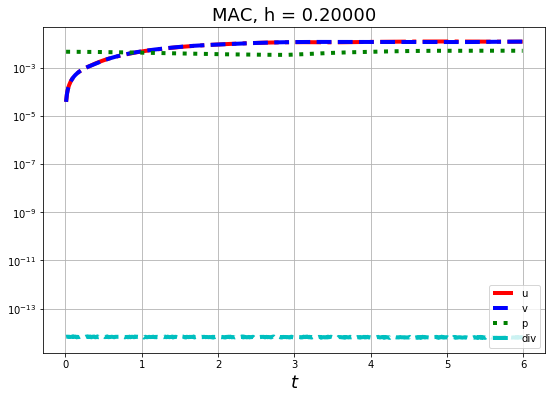

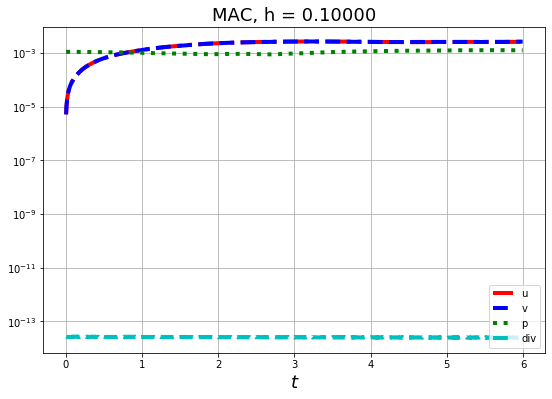

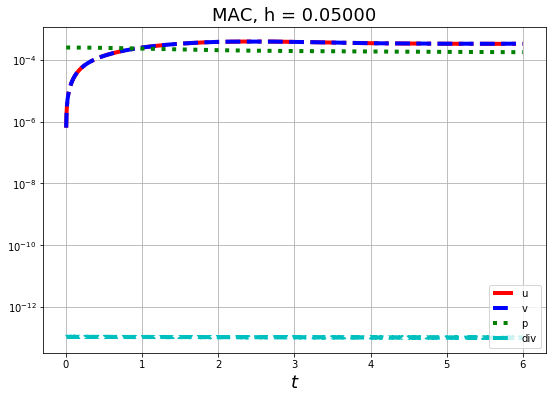

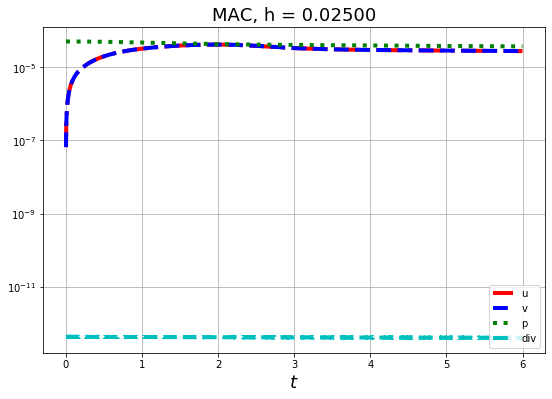

In [7]:
l = ['u', 'v', 'p', 'div']
for n, h, err in res:
    lstyle = cycle(('-.', '--', ':', '--'))
    color = cycle('rbgcmy')
    figure(figsize=(9, 6))
    title("MAC, h = %.5f" % h, {'fontsize': 18})
    for k in range(1, 5):
        semilogy(err[0,:n],\
                 err[k,:n],\
                 label="%s" % l[k-1],
                 linestyle=next(lstyle),
                 color=next(color),
                 linewidth=4)
    xlabel(r'$t$', {'fontsize': 18})
    grid()
    legend(loc='lower right', fancybox=True)
    #     savefig("taylor_decaying_uvp_mac.pdf")
    show()
    close()

In [8]:
print(r"""\begin{center}
MAC

\begin{tabular}{rrrrrr}\hline
\multicolumn{1}{c}{h} &
\multicolumn{1}{c}{t} &
\multicolumn{1}{c}{Error in u} &
\multicolumn{1}{c}{Error in v} &
\multicolumn{1}{c}{Error in p} &
\multicolumn{1}{c}{Error in div} \\ \hline""")
for n, h, err in res:
    print(r' {:.2e} & {:.2f} & {:.2e} & {:.2e} & {:.2e} & {:.2e} \\'\
          .format(h, err[0, n], err[1, n], err[2, n], err[3, n], err[4, n]))
print(r"""\hline
\end{tabular}
\end{center}
""")

\begin{center}
MAC

\begin{tabular}{rrrrrr}\hline
\multicolumn{1}{c}{h} &
\multicolumn{1}{c}{t} &
\multicolumn{1}{c}{Error in u} &
\multicolumn{1}{c}{Error in v} &
\multicolumn{1}{c}{Error in p} &
\multicolumn{1}{c}{Error in div} \\ \hline
 2.00e-01 & 6.00 & 1.19e-02 & 1.20e-02 & 4.98e-03 & 6.24e-15 \\
 1.00e-01 & 6.00 & 2.55e-03 & 2.61e-03 & 1.24e-03 & 2.54e-14 \\
 5.00e-02 & 6.00 & 3.28e-04 & 3.32e-04 & 1.75e-04 & 1.01e-13 \\
 2.50e-02 & 6.00 & 2.75e-05 & 2.76e-05 & 3.69e-05 & 4.07e-13 \\
\hline
\end{tabular}
\end{center}

